発想を変え、晴天時のデータのみを使い、地下水への浸透を利用してフィッティングを行う。

過去 n ヵ月の平均大気窒素酸化物濃度を利用する。


In [58]:
# 指定された局の、全期間のNOX値を抽出する。

import pandas as pd
from air import reader as airreader

# 吉田、大月、上野原
stations = ["19202030", "19206010", "19441030"]

# 欠測を補う
NOx = airreader.read_NOX_TD20231218_155555_51(
    "air/data/TD20231218_155555_51", stations
).interpolate()

NOx_hourly = airreader.monthly_to_hourly(NOx)

/Users/matto/Dropbox/論文KM2025/原稿/KM2025/air/reader.py:105: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range("2000/4/1", "2021/3/31", freq="H").tz_localize("Asia/Tokyo")


上野原大気測定局での窒素酸化物の推移。


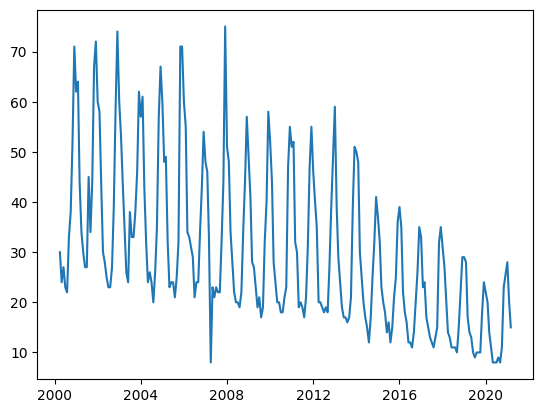

In [59]:
import matplotlib.pyplot as plt

plt.plot(NOx.index, NOx["19206010"], label="NOX")

N ヵ月の移動平均をとる。


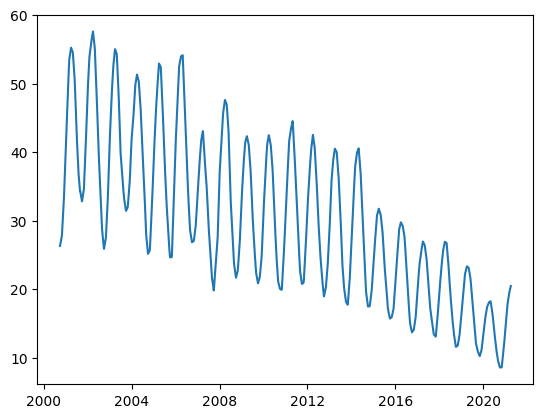

In [60]:
def rolling_average(hourly, months=6):
    # Thank you Gemini

    days_in_month_avg = 30
    window_size = months * days_in_month_avg * 24

    rolling_average = pd.DataFrame(index=hourly.index)
    for obs_air in stations:
        # center=Trueを指定すると、移動平均の中心が現在の時刻になります。
        # center=False (デフォルト) の場合は、過去のデータのみを使って平均を計算します。
        rolling_average[obs_air] = (
            hourly[obs_air].rolling(window=window_size, center=False).mean()
        )
    return rolling_average


nox_rolling6 = rolling_average(NOx_hourly, months=6)
plt.plot(nox_rolling6.index, nox_rolling6["19206010"], label="NOX")

NOx の極大極小を確認。


<Axes: xlabel='datetime'>

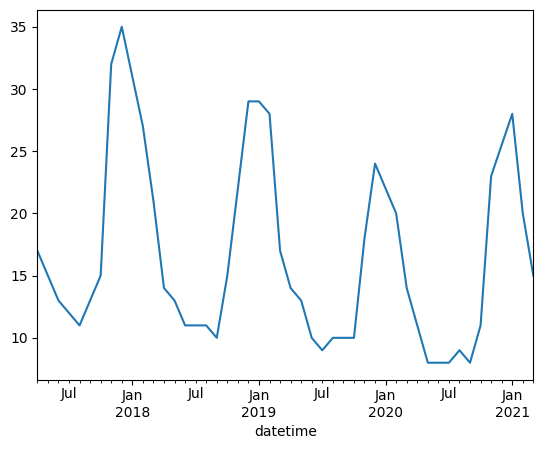

In [61]:
NOx["19206010"][-48:].plot()

In [62]:
import numpy as np
from dataclasses import dataclass
from typing import Union


@dataclass
class AvgStd:
    avg: Union[float, np.ndarray]
    std: Union[float, np.ndarray]


def powc(a: AvgStd, n: float):
    return AvgStd(a.avg**n, np.abs(a.std * n * a.avg ** (n - 1)))


def add3(a, b, c):
    return add(add(a, b), c)


def add(a, b):
    return AvgStd(avg=a.avg + b.avg, std=(a.std**2 + b.std**2) ** 0.5)


def div(a: AvgStd, b: AvgStd):
    cavg = a.avg / b.avg
    cstd = ((a.std / a.avg) ** 2 + (b.std / b.avg) ** 2) ** 0.5 * np.abs(cavg)
    return AvgStd(cavg, cstd)


def mul(a: AvgStd, b: AvgStd):
    cavg = a.avg * b.avg
    cstd = ((a.std / a.avg) ** 2 + (b.std / b.avg) ** 2) ** 0.5 * np.abs(cavg)
    return AvgStd(cavg, cstd)


def mulc(a: AvgStd, c: float):
    return AvgStd(a.avg * c, a.std * np.abs(c))


def neg(a):
    return mulc(a, -1)


def addc(a: AvgStd, c: float):
    return AvgStd(a.avg + c, a.std)

モデル v4(論文 KM2025 に採用)のフィッティング関数と誤差評価関数。


In [ ]:
def trend_v4(w, B, a, b):
    c, Fr, crP = w
    return B * c / Fr + a * crP + b


def error_core_v4(dfdB, dfda, dfdb, pcov):
    jacobian = np.array([dfdB, dfda, dfdb]).T
    x = jacobian @ pcov
    return np.sum(jacobian * x, axis=1) ** 0.5


def prop_of_errors_v4(w, pcov):
    c, Fr, crP = w
    dfdB = c / Fr
    dfda = crP
    dfdb = np.ones_like(crP)
    return error_core_v4(dfdB, dfda, dfdb, pcov)


def align_time_ticks_to(A, ref):
    return pd.merge(ref, A, on="datetime", how="left").iloc[:, 1:]


# def combine_and_dropna(*one_column_dfs):
# datetimeには1時間のずれがあるが、無視して最初のカラムの時刻を採用する。
# wc = air_N.to_numpy()[:,0]
# ic(wc)
# crN = river_N.value
# crP = river_P.value
# Fr = river_flow.value

# Xy = pd.DataFrame([river_N.index, wc, crP, crN, Fr]).transpose().dropna(axis=0)
# Xy.columns = ["dt", "wc", "crP", "crN", "Fr"]

# dt = Xy["dt"]
# wc1 = Xy["wc"]
# crP1 = Xy["crP"]
# crN1 = Xy["crN"]
# Fr1 = Xy["Fr"]

# Figure 3


/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/ipykernel_20936/2776950008.py:63: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  pl = ax.scatter(
/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/ipykernel_20936/2776950008.py:63: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  pl = ax.scatter(
/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/ipykernel_20936/2776950008.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([0.75,1,1.25,1.5,1.75,2,2.25])
/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/ipykernel_20936/2776950008.py:63: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled mar

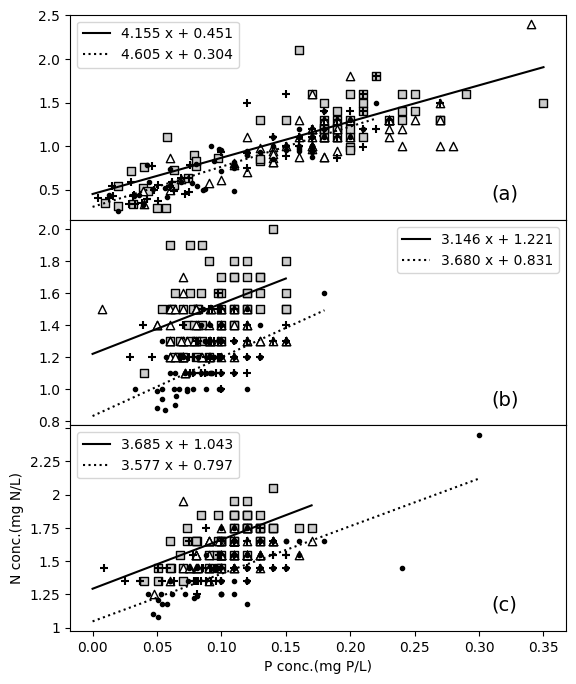

In [ ]:
import matplotlib.pyplot as plt
import flow.reader as flow_reader
import datetime as dt
import pytz
import scipy
import numpy as np

# 3枚のパネル
panels = {
    "a": dict(flow="昭和橋", air="19202030"),
    "b": dict(flow="大月橋", air="19206010"),
    "c": dict(flow="桂川橋", air="19441030"),
}

# 4つの時区間。
time_ranges = (
    (2000, 2004, "s", "#ccc", "k", "k-"),
    (2005, 2009, "^", "w", "k", None),
    (2010, 2014, "+", "k", "k", None),
    (2015, 2019, ".", "k", "k", "k:"),
)

# 図の大きさと配置
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(6.4, 8))
fig.subplots_adjust(hspace=0)

# パネルごとのループ
for j, (ax, (panel, observatory)) in enumerate(zip(axs, panels.items())):
    obs_flow = observatory["flow"]
    obs_air = observatory["air"]

    ax.annotate(f"({panel})", (0.85, 0.1), size=14, color="k", xycoords="axes fraction")

    #### 水質と流量 #################################################
    river_N = flow_reader.read_river_N("flow/data", obs_flow)
    river_P = flow_reader.read_river_P("flow/data", obs_flow)
    river_flow = flow_reader.read_river_flow("flow/data", obs_flow)

    if j == 2:
        ax.set_yticklabels([0.75, 1, 1.25, 1.5, 1.75, 2, 2.25])

    # -------------------------------------------------------------
    # 川のN/P比をプロットする
    for i, (
        ys,
        ye,
        marker,
        fill,
        edge,
        line,
    ) in enumerate(time_ranges):
        NP = pd.concat([river_N, river_P], axis=1)
        NP.columns = ("N", "P")
        # 時区間をきりとる
        ra = (NP.index > dt.datetime(ys, 1, 1, tzinfo=pytz.timezone("Asia/Tokyo"))) & (
            NP.index < dt.datetime(ye, 12, 31, tzinfo=pytz.timezone("Asia/Tokyo"))
        )
        NP = NP[ra]
        # 欠測を除去
        NP = NP.dropna()

        pl = ax.scatter(
            NP.P,
            NP.N,
            marker=marker,
            color=fill,
            edgecolors=edge,  # label=f"{ys}-{ye}"
        )
        # 最初と最後の5年間のみ、直線フィットする。
        if line is not None:
            (AA, BB), pcov = scipy.optimize.curve_fit(
                lambda x, A, B: A * x + B, NP.P, NP.N
            )
            X = np.linspace(0, NP.P.max(), 100)
            Y = AA * X + BB
            ax.plot(X, Y, line, label=f"{AA:.3f} x + {BB:.3f}")
    ax.legend()

plt.xlabel("P conc.(mg P/L)")
plt.ylabel("N conc.(mg N/L)")
fig.savefig(f"Figure3.pdf")
plt.show()

# Figure 5, Table S1


ic| B: np.float64(0.008454358450059938)
    a: np.float64(3.9962262948320744)
    b: np.float64(0.3495188243335883)
ic| B: np.float64(0.0168652281876698)
    a: np.float64(2.1329774910911934)
    b: np.float64(0.9438612481282435)
ic| B: np.float64(0.1506932538897766)
    a: np.float64(2.3328106152960046)
    b: np.

(244,) (244,) (244,)
B:0.008 t:2.748 p:0.00644
a:3.996 t:16.232 p:0.00000
b:0.350 t:12.847 p:0.00000
(245,) (245,) (245,)
B:0.017 t:12.588 p:0.00000
a:2.133 t:5.394 p:0.00000
b:0.944 t:24.146 p:0.00000


float64(0.948538587141636)
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothi

(245,) (245,) (245,)
B:0.151 t:5.998 p:0.00000
a:2.333 t:7.634 p:0.00000
b:0.949 t:29.800 p:0.00000


findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Font family 'IPAexGothic' not found.
findfont: Fon

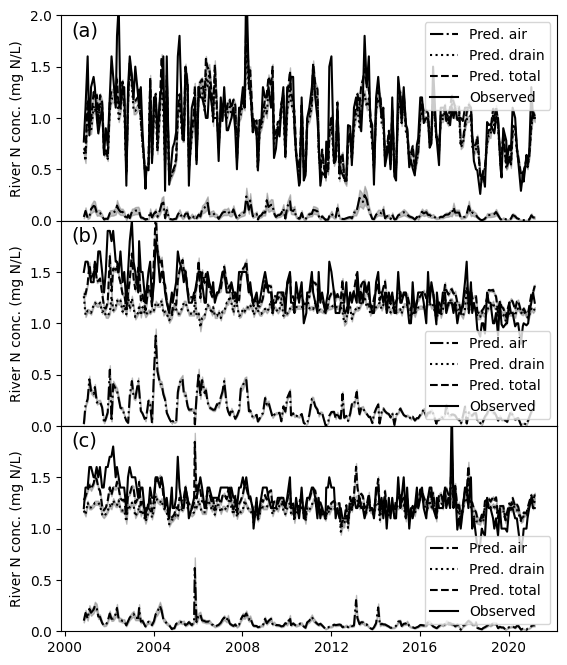

v          t             p
昭和橋 B  0.008454   2.748285  6.444004e-03
    a  3.996226  16.231800  0.000000e+00
    b  0.349519  12.846952  0.000000e+00
大月橋 B  0.016865  12.587688  0.000000e+00
    a  2.132977   5.394377  1.635336e-07
    b  0.943861  24.145725  0.000000e+00
桂川橋 B  0.150693   5.998054  7.227390e-09
    a  2.332811   7.633953  5.246914e-13
    b  0.948539  29.800411  0.000000e+00

In [ ]:
import matplotlib.pyplot as plt
import flow.reader as flow_reader

from icecream import ic


def plot_river_content(ax, x, cr, pred, pred_drain, pred_air):
    ax.plot(x, pred_drain, "k:", label="Pred. drain")
    ax.plot(x, pred_air, "k-.", label="Pred. air")
    ax.plot(x, pred, "k--", label="Pred. total")
    ax.plot(x, cr, "k-", alpha=0.5, label="Observed")
    ax.set_ylim(0, 2)
    ax.set_ylabel("River N conc. (mg N/L)")
    ax.legend()


# 3枚のパネル
panels = {
    "a": dict(flow="昭和橋", air="19202030"),
    "b": dict(flow="大月橋", air="19206010"),
    "c": dict(flow="桂川橋", air="19441030"),
}

fig, axs = plt.subplots(3, 1, figsize=(6.4, 8))
fig.subplots_adjust(hspace=0)

table_S1 = {}
table_S2 = {}


for i, (ax, (panel, observatory)) in enumerate(zip(axs, panels.items())):
    obs_flow = observatory["flow"]
    obs_air = observatory["air"]

    ax.annotate(f"({panel})", (0.02, 0.9), size=14, color="k", xycoords="axes fraction")
    if i > 0:
        ax.set_yticks([0, 0.5, 1, 1.5])
    if i < len(axs) - 1:
        ax.tick_params(axis="x", labelbottom=False)

    #### 水質と流量 #################################################
    river_N = flow_reader.read_river_N("flow/data", obs_flow)
    river_P = flow_reader.read_river_P("flow/data", obs_flow)
    river_flow = flow_reader.read_river_flow("flow/data", obs_flow)

    # データの時刻をそろえる。
    air_N = nox_rolling6[obs_air].resample("D").mean()
    river_N = river_N.resample("D").median()
    river_P = river_P.resample("D").median()
    river_flow = river_flow.resample("D").median()
    Xy = pd.concat([air_N, river_P, river_N, river_flow], axis=1).dropna()
    Xy.columns = ["wc", "crP", "crN", "Fr"]
    dt = Xy.index
    wc1 = Xy["wc"]
    crP1 = Xy["crP"]
    crN1 = Xy["crN"]
    Fr1 = Xy["Fr"]

    ###############################################################
    # 回帰で係数を推定する。
    w = (wc1, Fr1, crP1)
    popt, pcov = scipy.optimize.curve_fit(
        f=trend_v4,
        xdata=w,
        ydata=crN1,
        maxfev=12000,
    )
    B, a, b = popt

    ic(B, a, b)

    # -------------------------------------------------------------
    # 成分ごとの推定
    pred = trend_v4(w, B, a, b)
    pred_drain = trend_v4(w, 0, a, b)
    pred_air = trend_v4(w, B, 0, 0)
    dfdB = wc1 / Fr1
    dfda = crP1
    dfdb = np.ones_like(crP1)
    zeros = np.zeros_like(crP1)
    print(dfdB.shape, dfda.shape, dfdb.shape)
    error = error_core_v4(dfdB, dfda, dfdb, pcov)
    error_air = error_core_v4(dfdB, zeros, zeros, pcov)
    error_drain = error_core_v4(zeros, dfda, dfdb, pcov)

    def error_band_plot(ax, x, y, error, label, line):
        ax.plot(x, y, line, label=label)
        ax.fill_between(x, y - error, y + error, alpha=0.5, color="gray")

    # -------------------------------------------------------------
    error_band_plot(ax, dt, pred_air, error_air, label="Pred. air", line="k-.")
    error_band_plot(ax, dt, pred_drain, error_drain, label="Pred. drain", line="k:")
    error_band_plot(ax, dt, pred, error, label="Pred. total", line="k--")

    ax.plot(dt, crN1, "k-", label="Observed")
    ax.set_ylim(0, 2)
    ax.set_ylabel("River N conc. (mg N/L)")
    ax.legend()
    # -------------------------------------------------------------

    df = len(dt) - len(popt)

    t_value_B = B / pcov[0, 0] ** 0.5
    t_value_a = a / pcov[1, 1] ** 0.5
    t_value_b = b / pcov[2, 2] ** 0.5

    import scipy.stats as stats  # p値の計算に使用

    p_value_B = 2 * (1 - stats.t.cdf(t_value_B, df))
    p_value_a = 2 * (1 - stats.t.cdf(t_value_a, df))
    p_value_b = 2 * (1 - stats.t.cdf(t_value_b, df))

    print(f"B:{B:.3f} t:{t_value_B:.3f} p:{p_value_B:.5f}")
    print(f"a:{a:.3f} t:{t_value_a:.3f} p:{p_value_a:.5f}")
    print(f"b:{b:.3f} t:{t_value_b:.3f} p:{p_value_b:.5f}")

    table_S1[observatory["flow"], "B"] = {"v": B, "t": t_value_B, "p": p_value_B}
    table_S1[observatory["flow"], "a"] = {"v": a, "t": t_value_a, "p": p_value_a}
    table_S1[observatory["flow"], "b"] = {"v": b, "t": t_value_b, "p": p_value_b}

    Favg = Fr1.mean()
    C = B / Favg
    table_S2[observatory["flow"]] = {"B": B, "phi": Favg, "C": C}

fig.savefig(f"Figure5.pdf")
plt.show()

# make a table in markdown format
import pandas as pd

dfS1 = pd.DataFrame(table_S1)
dfS1.transpose()

In [122]:
dfS2 = pd.DataFrame(table_S2)
dfS2.transpose()

,B,phi,C
昭和橋,0.008454,2.476252,0.003414
大月橋,0.016865,5.423460,0.003110
桂川橋,0.150693,36.256953,0.004156


# Figure S3


ic| B: np.float64(0.008454358450059938)
    a: np.float64(3.9962262948320744)
    b: np.float64(0.3495188243335883)
ic| np.corrcoef(crN1, pred): array([[1.        , 0.85254558],
                                    [0.85254558, 1.        ]])


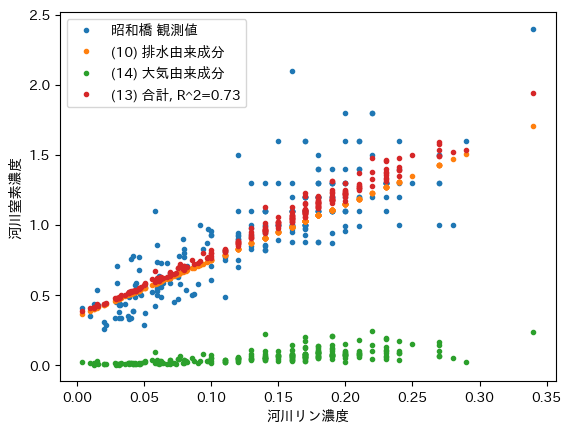

ic| B: np.float64(0.0168652281876698)
    a: np.float64(2.1329774910911934)
    b: np.float64(0.9438612481282435)
ic| np.corrcoef(crN1, pred): array([[1.        , 0.66364495],
                                    [0.66364495, 1.        ]])


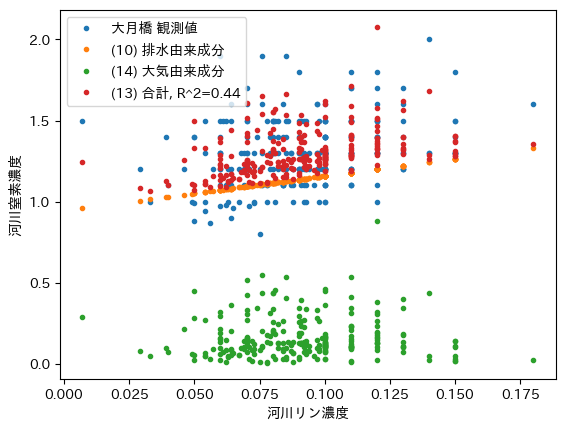

ic| B: np.float64(0.1506932538897766)
    a: np.float64(2.3328106152960046)
    b: np.float64(0.948538587141636)
ic| np.corrcoef(crN1, pred): array([[1.        , 0.59941716],
                                    [0.59941716, 1.        ]])


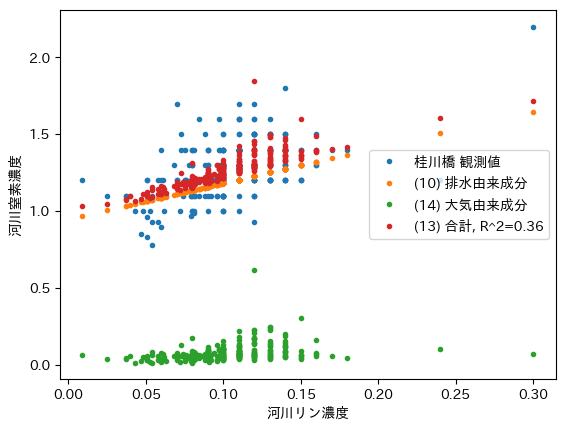

In [85]:
import matplotlib.pyplot as plt
import flow.reader as flow_reader

import japanize_matplotlib
from icecream import ic
import numpy as np
from sklearn.metrics import r2_score

# 3枚のパネル
panels = {
    "a": dict(flow="昭和橋", air="19202030"),
    "b": dict(flow="大月橋", air="19206010"),
    "c": dict(flow="桂川橋", air="19441030"),
}


for panel, observatory in panels.items():
    obs_flow = observatory["flow"]
    obs_air = observatory["air"]

    #### 水質と流量 #################################################
    river_N = flow_reader.read_river_N("flow/data", obs_flow)
    river_P = flow_reader.read_river_P("flow/data", obs_flow)
    river_flow = flow_reader.read_river_flow("flow/data", obs_flow)

    # データの時刻をそろえる。
    air_N = nox_rolling6[obs_air].resample("D").mean()
    river_N = river_N.resample("D").median()
    river_P = river_P.resample("D").median()
    river_flow = river_flow.resample("D").median()
    Xy = pd.concat([air_N, river_P, river_N, river_flow], axis=1).dropna()
    Xy.columns = ["wc", "crP", "crN", "Fr"]
    dt = Xy.index
    wc1 = Xy["wc"]
    crP1 = Xy["crP"]
    crN1 = Xy["crN"]
    Fr1 = Xy["Fr"]

    ###############################################################
    w = (wc1, Fr1, crP1)
    popt, pcov = scipy.optimize.curve_fit(
        trend_v4,
        w,
        crN1,
        maxfev=12000,
    )
    B, a, b = popt

    ic(B, a, b)

    # -------------------------------------------------------------
    pred = trend_v4(w, *popt)
    pred_drain = trend_v4(w, 0, a, b)
    pred_air = trend_v4(w, B, 0, 0)

    ic(np.corrcoef(crN1, pred))

    ###############################################################

    # -------------------------------------------------------------

    fig = plt.figure()
    # plot raw
    plt.plot(crP1, crN1, ".", label=f"{obs_flow} 観測値")

    # plot eq (4.6)
    plt.plot(crP1, pred_drain, ".", label="(10) 排水由来成分")

    # plot eq (4.7)
    plt.plot(crP1, pred_air, ".", label="(14) 大気由来成分")

    # plot eq (4.5)
    plt.plot(crP1, pred, ".", label=f"(13) 合計, R^2={r2_score(crN1, pred):.2f}")

    plt.xlabel("河川リン濃度")
    plt.ylabel("河川窒素濃度")
    plt.legend()
    fig.savefig(f"FigureS2{panel}.pdf")
    plt.show()
    # -------------------------------------------------------------

# Figure 6


ic| B: np.float64(0.008454358450059938)
    a: np.float64(3.9962262948320744)
    b: np.float64(0.3495188243335883)
ic| np.mean(composition.avg): np.float64(5.8585347334554285)
ic| B: np.float64(0.0168652281876698)
    a: np.float64(2.1329774910911934)
    b: np.float64(0.9438612481282435)
ic| np.mean(composition.avg): np.float64(11.690113017677776)
ic| B: np.float64(0.1506932538897766)
    a: np.float64(2.3328106152960046)
    b: np.float64(0.948538587141636)
ic| np.mean(composition.avg): np.float64(6.2518640320133825)


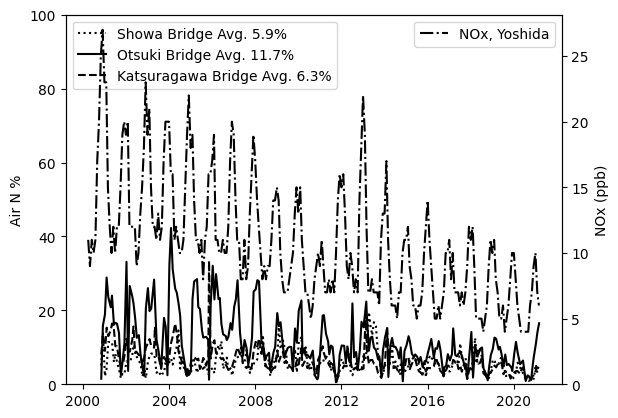

In [82]:
import matplotlib.pyplot as plt
import flow.reader as flow_reader

from icecream import ic
import numpy as np


def plot_river_composition(
    ax, x, pred, error, pred_air, error_air, ylabel="Air N %", line="-", label=""
):
    total = AvgStd(avg=pred, std=error)
    air = AvgStd(
        avg=pred_air,
        std=error_air,
    )

    composition = mulc(div(air, total), 100)
    ic(np.mean(composition.avg))
    ax.plot(
        x, composition.avg, line, label=f"{label} Avg. {np.mean(composition.avg):.1f}%"
    )
    ax.set_ylim(0, 100)
    ax.set_ylabel(ylabel)


panels = {
    "a": dict(flow="昭和橋", air="19202030", line="k:", label="Showa Bridge"),
    "b": dict(flow="大月橋", air="19206010", line="k-", label="Otsuki Bridge"),
    "c": dict(flow="桂川橋", air="19441030", line="k--", label="Katsuragawa Bridge"),
}


fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

for panel, observatory in panels.items():
    obs_flow = observatory["flow"]
    obs_air = observatory["air"]
    line = observatory["line"]
    label = observatory["label"]

    #### 水質と流量 #################################################
    river_N = flow_reader.read_river_N("flow/data", obs_flow)
    river_P = flow_reader.read_river_P("flow/data", obs_flow)
    river_flow = flow_reader.read_river_flow("flow/data", obs_flow)

    # データの時刻をそろえる。
    air_N = nox_rolling6[obs_air].resample("D").mean()
    river_N = river_N.resample("D").median()
    river_P = river_P.resample("D").median()
    river_flow = river_flow.resample("D").median()
    Xy = pd.concat([air_N, river_P, river_N, river_flow], axis=1).dropna()
    Xy.columns = ["wc", "crP", "crN", "Fr"]
    dt = Xy.index
    wc1 = Xy["wc"]
    crP1 = Xy["crP"]
    crN1 = Xy["crN"]
    Fr1 = Xy["Fr"]

    ###############################################################
    w = (wc1, Fr1, crP1)
    popt, pcov = scipy.optimize.curve_fit(
        trend_v4,
        w,
        crN1,
        maxfev=12000,
    )
    B, a, b = popt

    ic(B, a, b)

    # 成分比 #######################################################
    pred = trend_v4(w, B, a, b)
    error = prop_of_errors_v4(w, pcov)
    pred_air = trend_v4(w, B, 0, 0)
    error_air = prop_of_errors_v4(w, pcov)

    # -------------------------------------------------------------
    plot_river_composition(
        ax1,
        dt,
        pred,
        error,
        pred_air,
        error_air,
        line=line,
        label=label,
        # title=f"{obs_flow} 大気由来",
    )
ax1.legend(loc="upper left")
# →の軸で、窒素濃度をプロットする。
ax2.plot(NOx.index, NOx["19202030"], "k-.", label="NOx, Yoshida")
ax2.set_ylim(0, None)
ax2.set_ylabel("NOx (ppb)")
ax2.legend(loc="upper right")
fig.savefig(f"Figure6.pdf")
plt.show()
# -------------------------------------------------------------

# Table 2


In [ ]:
import matplotlib.pyplot as plt
import flow.reader as flow_reader
from IPython.display import Markdown, display
from icecream import ic
import numpy as np


def printmd(string):
    display(Markdown(string))


panels = {
    "a": dict(flow="昭和橋", air="19202030", line="k:", en="Showa Br."),
    "b": dict(flow="大月橋", air="19206010", line="k-", en="Otsuki Br."),
    "c": dict(flow="桂川橋", air="19441030", line="k--", en="Katsuragawa Br."),
}

# Thank you Gemini

days_in_month_avg = 30


# Column headers
s = "|Span (mo.)   |"
for panel in panels:
    s += f"{panels[panel]['en']} |"
s += "\n"

# Horizontal bar
s += "|----|"
for panel in panels:
    s += f"----|"
s += "\n"


for N in (1, 3, 6, 12, 24, 48):
    s += f"|**{N}**|"
    nox_rollingN = rolling_average(NOx_hourly, N)

    for panel, observatory in panels.items():
        obs_flow = observatory["flow"]
        obs_air = observatory["air"]
        line = observatory["line"]

        #### 水質と流量 #################################################
        river_N = flow_reader.read_river_N("flow/data", obs_flow)
        river_P = flow_reader.read_river_P("flow/data", obs_flow)
        river_flow = flow_reader.read_river_flow("flow/data", obs_flow)

        # データの時刻をそろえる。
        air_N = nox_rollingN[obs_air].resample("D").mean()
        river_N = river_N.resample("D").median()
        river_P = river_P.resample("D").median()
        river_flow = river_flow.resample("D").median()
        Xy = pd.concat([air_N, river_P, river_N, river_flow], axis=1).dropna()
        Xy.columns = ["wc", "crP", "crN", "Fr"]
        dt = Xy.index
        wc1 = Xy["wc"]
        crP1 = Xy["crP"]
        crN1 = Xy["crN"]
        Fr1 = Xy["Fr"]

        ###############################################################
        w = (wc1, Fr1, crP1)
        popt, pcov = scipy.optimize.curve_fit(
            trend_v4,
            w,
            crN1,
            maxfev=12000,
        )
        B, a, b = popt

        # ic(B, a, b)

        # 成分比 #######################################################
        pred = trend_v4(w, B, a, b)
        error = prop_of_errors_v4(w, pcov)
        pred_air = trend_v4(w, B, 0, 0)
        error_air = prop_of_errors_v4(w, pcov)

        # -------------------------------------------------------------
        total = AvgStd(avg=pred, std=error)
        air = AvgStd(
            avg=pred_air,
            std=error_air,
        )
        composition = mulc(div(air, total), 100)
        s += f"{np.mean(composition.avg):.1f} |"
    s += "\n"
printmd(s)

|Span (mo.)   |Showa Br. |Otsuki Br. |Katsuragawa Br. |
|----|----|----|----|
|**1**|11.7 |9.1 |4.9 |
|**3**|8.8 |9.7 |5.9 |
|**6**|5.9 |11.7 |6.3 |
|**12**|6.1 |14.2 |4.8 |
|**24**|6.2 |13.9 |3.5 |
|**48**|5.2 |13.8 |2.1 |


# Figure 1


In [41]:
from shapely.ops import unary_union
import geopandas as gpd
import pandas as pd


神奈川shape = f"basin/W12-52A-14-01.1_GML/W12-52A_14_WatershedBoundary.shp"
神奈川basin = gpd.read_file(神奈川shape, engine="fiona")
山梨shape = f"basin/W12-52A-19-01.1_GML/W12-52A_19_WatershedBoundary.shp"
山梨basin = gpd.read_file(山梨shape, engine="fiona")
basin = pd.concat([山梨basin, 神奈川basin], axis=0, ignore_index=True)
basin


神奈川shape = f"basin/W05-08_14_GML/W05-08_14-g_Stream.shp"
神奈川branch = gpd.read_file(神奈川shape)
山梨shape = f"basin/W05-08_19_GML/W05-08_19-g_Stream.shp"
山梨branch = gpd.read_file(山梨shape)
branch = pd.concat([山梨branch, 神奈川branch], axis=0, ignore_index=True)


import json

with open("air/stations.json", "r") as f:
    stations_loc = json.load(f)
stations_loc

# Shapefileを読み込む
fp = "basin/N03-20240101_14_GML/N03-20240101_14.shp"
kanagawa = gpd.read_file(fp, encoding="cp932")
fp = "basin/N03-20240101_19_GML/N03-20240101_19.shp"
yamanashi = gpd.read_file(fp, encoding="cp932")

polygons = yamanashi["geometry"]
yb = gpd.GeoSeries(unary_union(polygons))
# yb.plot(color="red")

polygons = kanagawa["geometry"]
kb = gpd.GeoSeries(unary_union(polygons))
# kb.plot(color="blue")
# plt.show()

bridges = {
    "Katsuragawa Br.": (35.6167306, 139.1171345),  #
    # "境川橋": (35.61726232577428, 139.13838232748358),  #
    "Otsuki Br.": (35.60887308, 138.93663348),
    # "富士見橋": (35.52293, 138.84808),  # 35.52293、138.84808
    "Showa Br.": (35.49653, 138.80937),
    "Sagami Lake": (35 + 36 / 60 + 43 / 3600, 139 + 11 / 60 + 3 / 3600),
}

generators = {
    "Kawamo intake": (35.574903, 138.920297),
    "Matsudome outlet": (35.616005, 139.109493),
}

basins = ["83032", "83953", "83954"]  # 相模川、河口湖、西湖
colors = ["#dfd", "#fdd", "#ddd"]

bcolors = {
    "Y-2": "red",
    "Y-3": "red",
    "Y-1": "orange",
    "Y-4": "orange",
    "Y-5": "yellow",
    "Y-6": "yellow",
    "Y-7": "lime",
}


# 大気測定局
stations = {"19202030": "Yoshida", "19206010": "Otsuki", "19441030": "Uenohara"}

/Users/matto/Dropbox/論文KM2025/原稿/KM2025/.venv/lib/python3.11/site-packages/pyogrio/raw.py:198: RuntimeWarning: One or several characters couldn't be converted correctly from cp932 to UTF-8.  This warning will not be emitted anymore
  return ogr_read(
/Users/matto/Dropbox/論文KM2025/原稿/KM2025/.venv/lib/python3.11/site-packages/pyogrio/raw.py:198: RuntimeWarning: One or several characters couldn't be converted correctly from cp932 to UTF-8.  This warning will not be emitted anymore
  return ogr_read(


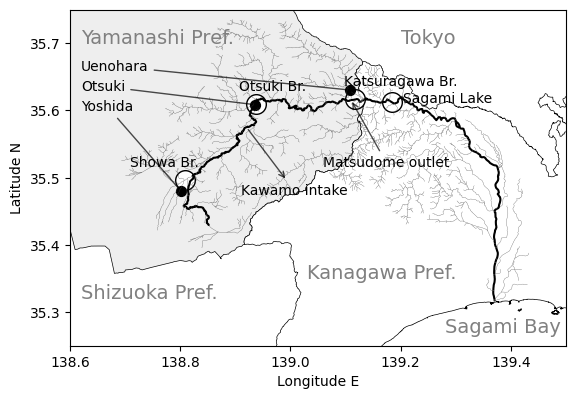

In [ ]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()


# 県の輪郭線を描く

yb.plot(ax=ax1, edgecolor="k", facecolor="#eee", linewidth=0.5)
kb.plot(ax=ax1, edgecolor="k", facecolor="white", linewidth=0.5)
県名, 輪郭 = "Yamanashi Pref.", yb
center = 輪郭.centroid[0]
県名, 輪郭 = "Kanagawa Pref.", kb
center = 輪郭.centroid[0]
ax1.annotate("Yamanashi Pref.", (138.62, 35.7), size=14, color="gray")
ax1.annotate("Kanagawa Pref.", (139.03, 35.35), size=14, color="gray")
ax1.annotate("Tokyo", (139.2, 35.7), size=14, color="gray")
ax1.annotate("Shizuoka Pref.", (138.62, 35.32), size=14, color="gray")
ax1.annotate("Sagami Bay", (139.28, 35.27), size=14, color="gray")


# 相模川全線を描く。
sagami = branch[branch["W05_001"].str.contains("830307")]
sagami.plot(ax=ax1, color="#444", linewidth=0.2)

branch[branch["W05_004"].str.contains("相模川")].loc[:, "geometry"].plot(
    ax=ax1, color="black", label="Sagami river"
)

# 流末測定点
markersX = []
markersY = []
for b, p in bridges.items():
    markersX.append(p[1])
    markersY.append(p[0])
    xoffset = -0.03
    yoffset = +0.02
    if b in ("Sagami Lake",):
        xoffset = +0.02
        yoffset = 0
    elif b in ("Katsuragawa Br.",):
        xoffset = -0.02
        yoffset = +0.02
    elif b in ("Showa Br.",):
        xoffset = -0.1
        yoffset = +0.02
    elif b in ("Uenohara",):
        xoffset = -0.1
        yoffset = -0.05
    ax1.annotate(
        b,
        (p[1] + xoffset, p[0] + yoffset),
        #  size=24,
        color="k",
    )
ax1.scatter(markersX, markersY, marker="o", color="w", edgecolors="k", s=200)

# 発電所取水と排水
markersX = []
markersY = []
for b, p in generators.items():
    markersX.append(p[1])
    markersY.append(p[0])
    xoffset = -0.01
    yoffset = -0.1
    arrowstyle = "<-"
    if b in ("Matsudome outlet",):
        xoffset = -0.05
        yoffset = -0.1
        arrowstyle = "->"
    # elif b in ("Katsuragawa Br.",):
    #     yoffset = -0.05
    ax1.annotate(
        b,
        xytext=(p[1] + xoffset, p[0] + yoffset),
        xy=(p[1], p[0]),  # markerの実際の位置
        arrowprops=dict(
            arrowstyle=arrowstyle,
            connectionstyle="arc3",
            color="black",
            lw=1,
            alpha=0.7,
        ),
        color="k",
    )
    # )ax1.scatter(markersX, markersY, marker="^", color="w", edgecolors="k", s=200)

for i, (station, ename) in enumerate(stations.items()):
    textx = 138.62
    texty = 35.6 + 0.03 * i
    ax1.annotate(
        ename,
        # xycoords=('axes fraction', 'data'),  # テキストはフレーム相対、矢印終点はデータ座標
        xy=(
            stations_loc[station]["longitude"],
            stations_loc[station]["latitude"],
        ),
        # stations_loc[station]["name"],
        xytext=(textx, texty),
        arrowprops=dict(
            arrowstyle="-", connectionstyle="arc3", color="black", lw=1, alpha=0.7
        ),
        # size=24,
        color="k",
    )
    ax1.scatter(
        stations_loc[station]["longitude"],
        stations_loc[station]["latitude"],
        marker=".",
        color="k",
        s=200,
    )


# ax1.s91/111
ax1.set_xlim(138.6, 139.5)
ax1.set_ylim(35.25, 35.75)
# ax1.legend()
ax1.set_aspect(111 / 91)
ax1.set_xlabel("Longitude E")
ax1.set_ylabel("Latitude N")

fig.savefig("Figure1.pdf")

# Figure 4


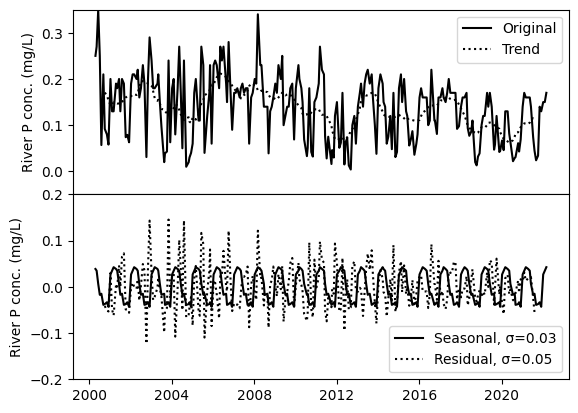

In [81]:
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import flow.reader as flow_reader
import matplotlib.pyplot as plt

obs_flow = "昭和橋"
river_N = flow_reader.read_river_N("flow/data", obs_flow)
river_P = flow_reader.read_river_P("flow/data", obs_flow)
river_flow = flow_reader.read_river_flow("flow/data", obs_flow)

decomposed = seasonal_decompose(river_P.value, model="additive", period=12)
fig, axs = plt.subplots(2, 1, sharex=True)
fig.subplots_adjust(hspace=0)
# plot = decomposed.plot()

axs[0].plot(river_P.value, "k-", label="Original")
axs[0].plot(decomposed.trend, "k:", label="Trend")
axs[0].set_ylim(-0.05, 0.35)
axs[0].set_ylabel("River P conc. (mg/L)")
axs[0].legend()

ssig = decomposed.seasonal.std()
rsig = decomposed.resid.std()
axs[1].plot(decomposed.seasonal, "k-", label=f"Seasonal, σ={ssig:.2f}")
axs[1].plot(decomposed.resid, "k:", label=f"Residual, σ={rsig:.2f}")
axs[1].set_ylim(-0.2, +0.2)
axs[1].set_ylabel("River P conc. (mg/L)")
axs[1].legend()

# plt.tight_layout()
fig.savefig("Figure4.pdf")
plt.show()

# Figure 2


/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/ipykernel_20936/1273548621.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_yticklabels([-10,-5,0,5])


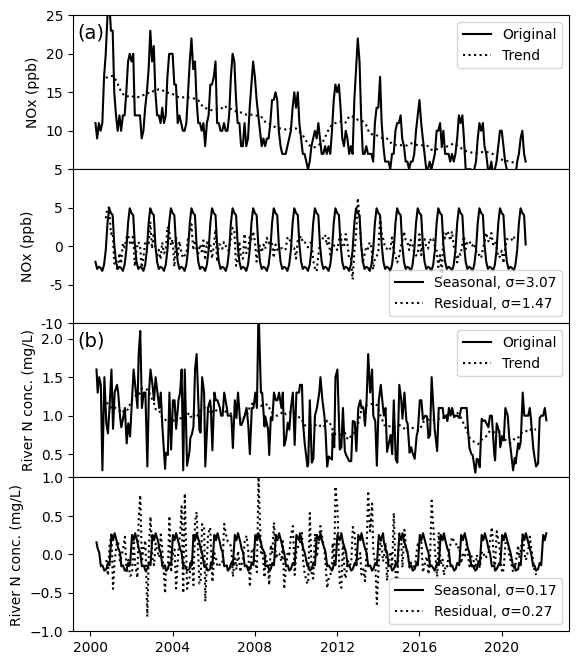

In [ ]:
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import flow.reader as flow_reader
import matplotlib.pyplot as plt

obs_flow = "昭和橋"
river_N = flow_reader.read_river_N("flow/data", obs_flow)
river_P = flow_reader.read_river_P("flow/data", obs_flow)
river_flow = flow_reader.read_river_flow("flow/data", obs_flow)

decomposed = seasonal_decompose(NOx["19202030"], model="additive", period=12)
fig, axs = plt.subplots(4, 1, figsize=(6.4, 8), sharex=True)
fig.subplots_adjust(hspace=0)

axs[0].plot(NOx["19202030"], "k-", label="Original")
axs[0].plot(decomposed.trend, "k:", label="Trend")
axs[0].set_ylim(5.0, 25.0)
axs[0].set_ylabel("NOx (ppb)")
axs[0].legend()
axs[0].annotate("(a)", (0.01, 0.85), size=14, color="k", xycoords="axes fraction")

ssig = decomposed.seasonal.std()
rsig = decomposed.resid.std()
axs[1].plot(decomposed.seasonal, "k-", label=f"Seasonal, σ={ssig:.2f}")
axs[1].plot(decomposed.resid, "k:", label=f"Residual, σ={rsig:.2f}")
axs[1].set_ylim(-10.0, +10.0)
axs[1].set_ylabel("NOx (ppb)")
axs[1].legend()
axs[1].set_yticklabels([-10, -5, 0, 5])

decomposed = seasonal_decompose(river_N.value, model="additive", period=12)
# fig, axs = plt.subplots(2, 1, sharex=True)
# fig.subplots_adjust(hspace=0)
# plot = decomposed.plot()

axs[2].plot(river_N.value, "k-", label="Original")
axs[2].plot(decomposed.trend, "k:", label="Trend")
axs[2].set_ylim(0.2, 2.2)
axs[2].set_ylabel("River N conc. (mg/L)")
axs[2].legend()
axs[2].annotate("(b)", (0.01, 0.85), size=14, color="k", xycoords="axes fraction")

ssig = decomposed.seasonal.std()
rsig = decomposed.resid.std()
axs[3].plot(decomposed.seasonal, "k-", label=f"Seasonal, σ={ssig:.2f}")
axs[3].plot(decomposed.resid, "k:", label=f"Residual, σ={rsig:.2f}")
axs[3].set_ylim(-1.0, +1.0)
axs[3].set_ylabel("River N conc. (mg/L)")
axs[3].legend()

# plt.tight_layout()
fig.savefig("Figure2.pdf")
plt.show()

# Figure S2


/Users/matto/My Drive/DataAnalysis/相模湖・津久井湖土地・水質/論文2025/原稿/KM2025/air/reader.py:105: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range("2000/4/1", "2021/3/31", freq="H").tz_localize("Asia/Tokyo")


array([[1.        , 0.14506731],
       [0.14506731, 1.        ]])

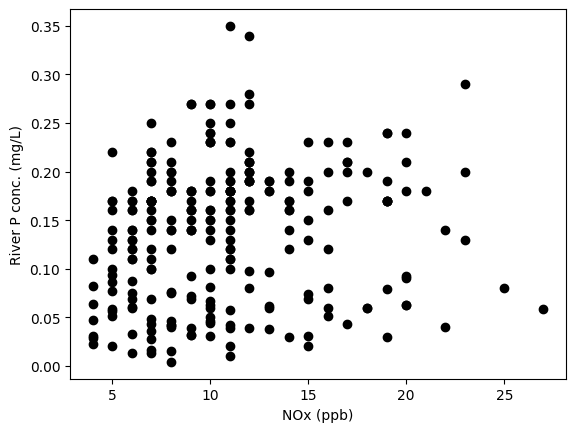

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import flow.reader as flow_reader
from air import reader as airreader

stations = ["19202030", "19206010", "19441030"]

NOx = airreader.read_NOX_TD20231218_155555_51(
    "air/data/TD20231218_155555_51", stations
).interpolate()

NOx_hourly = airreader.monthly_to_hourly(NOx)

obs_flow = "昭和橋"
river_N = flow_reader.read_river_N("flow/data", obs_flow)
river_P = flow_reader.read_river_P("flow/data", obs_flow)
river_flow = flow_reader.read_river_flow("flow/data", obs_flow)

obs_air = "19202030"
merged = pd.merge(river_P, NOx_hourly[obs_air], on="datetime", how="left").dropna()
# plt.scatter(nox2, river_N.value)
fig = plt.figure()
plt.scatter(merged[obs_air], merged.value, color="k")
plt.xlabel("NOx (ppb)")
plt.ylabel("River P conc. (mg/L)")
fig.savefig("Figure S1.pdf")

np.corrcoef(merged[obs_air], merged.value)

# Figure S1


/Users/matto/Dropbox/論文KM2025/原稿/KM2025/air/reader.py:105: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range("2000/4/1", "2021/3/31", freq="H").tz_localize("Asia/Tokyo")


array([[1.        , 0.27547833],
       [0.27547833, 1.        ]])

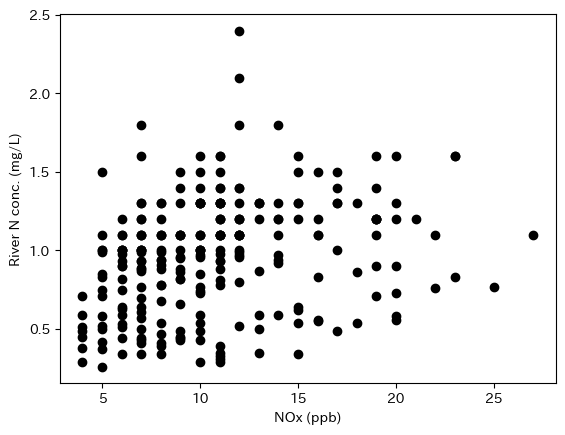

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import flow.reader as flow_reader
from air import reader as airreader

stations = ["19202030", "19206010", "19441030"]

NOx = airreader.read_NOX_TD20231218_155555_51(
    "air/data/TD20231218_155555_51", stations
).interpolate()

NOx_hourly = airreader.monthly_to_hourly(NOx)

obs_flow = "昭和橋"
river_N = flow_reader.read_river_N("flow/data", obs_flow)
river_P = flow_reader.read_river_P("flow/data", obs_flow)
river_flow = flow_reader.read_river_flow("flow/data", obs_flow)

obs_air = "19202030"
merged = pd.merge(river_N, NOx_hourly[obs_air], on="datetime", how="left").dropna()
# plt.scatter(nox2, river_N.value)
fig = plt.figure()
plt.scatter(merged[obs_air], merged.value, color="k")
plt.xlabel("NOx (ppb)")
plt.ylabel("River N conc. (mg/L)")
fig.savefig("Figure S1.pdf")

np.corrcoef(merged[obs_air], merged.value)